# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034L,)
test label shape: (677L,)
dev label shape: (676L,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [4]:
def P1(num_examples=5):
### STUDENT START ###
    for i in range(0, num_examples):
        print "Label: " + `newsgroups_train.target_names[train_labels[i]]`
        print train_data[i]
        print "============================\n"
### STUDENT END ###
P1(5)

Label: 'comp.graphics'
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Label: 'talk.religion.misc'


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

Label: '

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [7]:
def P2():
### STUDENT START ###
    vect = CountVectorizer()
    count = vect.fit_transform(train_data)
    vocabTrain = vect.vocabulary_
    print "a. Size of vocabulary: " + `(count.get_shape()[1])`
    print "a. Average non-zero features per example: " + `(count.getnnz()/count.get_shape()[0])`
    print "a. Fraction of non-zero entries (%): " + `100*(count.getnnz()/float(count.get_shape()[0] * count.get_shape()[1]))`
    print "b. First feature string: " + vect.get_feature_names()[0]
    print "b. Last feature string: " + vect.get_feature_names()[count.get_shape()[1]-1]
    vocab = ["atheism", "graphics", "space", "religion"]
    modVect = CountVectorizer(vocabulary=vocab)
    modCount = modVect.fit_transform(train_data)
    print "c. Average non-zero features per example with new vocab: " + `(modCount.getnnz()/float(modCount.get_shape()[0]))`
    biTriVect = CountVectorizer(ngram_range=(2,3), analyzer="char")
    biTriCount = biTriVect.fit_transform(train_data)
    print "d. Bigram and tigram size of vocabulary: " + `biTriCount.get_shape()[1]`
    tenDocPct = 10 / float(count.get_shape()[0])
    minDfVect = CountVectorizer(min_df=tenDocPct)
    minDfCount = minDfVect.fit_transform(train_data)
    print "e. MinDF size of vocabulary: " + `minDfCount.get_shape()[1]`
    devCount = vect.fit_transform(dev_data)
    vocabDev = vect.vocabulary_
    missing = 0
    for w in vocabDev.keys():
        if w not in vocabTrain.keys():            
            missing += 1
    print "f. Fraction of the words in the dev data that are missing from the vocabulary: " + `(missing/float(len(vocabDev)))`
### STUDENT END ###
P2()

a. Size of vocabulary: 26879
a. Average non-zero features per example: 96
a. Fraction of non-zero entries (%): 0.3597827226959026
b. First feature string: 00
b. Last feature string: zyxel
c. Average non-zero features per example with new vocab: 0.26843657817109146
d. Bigram and tigram size of vocabulary: 35478
e. MinDF size of vocabulary: 3064
f. Fraction of the words in the dev data that are missing from the vocabulary: 0.24787640034470024


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [244]:
def P3():
### STUDENT START ###
    vect = CountVectorizer()
    count_train = vect.fit_transform(train_data)

    # K Nearest Neighbor
    kValues = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20]    
    clf = KNeighborsClassifier(weights='distance')
    gscv = GridSearchCV(clf, {'n_neighbors': kValues})
    gscv.fit(count_train, train_labels)

    print "Optimal k for nearest neighbor classifier: " + `gscv.best_params_.values()[0]`

    clf = KNeighborsClassifier(n_neighbors = gscv.best_params_.values()[0], weights='distance')
    clf.fit(count_train, train_labels)
    
    count_dev = vect.transform(dev_data)
    preds = clf.predict(count_dev)
    f1_score = metrics.f1_score(dev_labels, preds)
    print "F1 score for nearest neighbor classifier: " + `f1_score`
    
    # MultinomialNB
    alphaValues = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]    
    clf = MultinomialNB(class_prior=None, fit_prior=True)
    gscv = GridSearchCV(clf, {'alpha': alphaValues})
    gscv.fit(count_train, train_labels)

    print "Optimal alpha for multinomial naive bayes: " + `gscv.best_params_.values()[0]`
    
    clf = MultinomialNB(class_prior=None, fit_prior=True, alpha=gscv.best_params_.values()[0])
    clf.fit(count_train, train_labels)
    
    preds = clf.predict(count_dev)
    f1_score = metrics.f1_score(dev_labels, preds)
    print "F1 score for multinomial naive bayes: " + `f1_score`
   
    # Logistic Regression
    cValues = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 5.0, 10.0, 25.0, 50.0, 100.0]    
    clf = LogisticRegression(penalty='l2')
    gscv = GridSearchCV(clf, {'C': cValues})
    gscv.fit(count_train, train_labels)

    print "Optimal C for logistic regression: " + `gscv.best_params_.values()[0]`
    
    clf = LogisticRegression(penalty='l2', C=gscv.best_params_.values()[0])
    clf.fit(count_train, train_labels)
    
    preds = clf.predict(count_dev)
    f1_score = metrics.f1_score(dev_labels, preds)
    print "F1 score for logistic regression: " + `f1_score`
    
    for k in range(0, len(cValues)):
        clf = LogisticRegression(C=cValues[k], penalty='l2')
        vect = CountVectorizer()
        count_train = vect.fit_transform(train_data)
        clf.fit(count_train, train_labels)
        coefs = clf.coef_    
        sumSqrWgt = 0
        for i in range(0, len(coefs)):        
            for j in range(0, len(coefs[i])):            
                sumSqrWgt = sumSqrWgt + coefs[i][j] * coefs[i][j]
        print "C: " + `cValues[k]` + " Sum Sqr Weight: " + `sumSqrWgt`
    ### STUDENT END ###
P3()

Optimal k for nearest neighbor classifier: 12
F1 score for nearest neighbor classifier: 0.44092317276254384
Optimal alpha for multinomial naive bayes: 0.1
F1 score for multinomial naive bayes: 0.79030523850988621
Optimal C for logistic regression: 0.2
F1 score for logistic regression: 0.70587336939811174
C: 0.1 Sum Sqr Weight: 102.26863474496379
C: 0.2 Sum Sqr Weight: 184.49253906318009
C: 0.3 Sum Sqr Weight: 254.83977788500056
C: 0.4 Sum Sqr Weight: 317.22417653627878
C: 0.5 Sum Sqr Weight: 373.70505706303055
C: 0.6 Sum Sqr Weight: 425.72166354180951
C: 0.7 Sum Sqr Weight: 473.88532150873073
C: 0.8 Sum Sqr Weight: 518.90096888996914
C: 0.9 Sum Sqr Weight: 561.50013491670461
C: 1.0 Sum Sqr Weight: 601.63861920221473
C: 1.5 Sum Sqr Weight: 776.6790246563362
C: 2.0 Sum Sqr Weight: 922.08057993648163
C: 5.0 Sum Sqr Weight: 1514.1860357834182
C: 10.0 Sum Sqr Weight: 2104.6762896240057
C: 25.0 Sum Sqr Weight: 3103.7582261463817
C: 50.0 Sum Sqr Weight: 4037.9363698124753
C: 100.0 Sum Sqr Wei

ANSWER:
a. K-Nearest Neighbor classifier is too simple to be able to handle a high number of features (25k+). This makes it difficult to classify a nearest neighbor accurately.
b. Logistic Regression is not ideal when the number of features is significantly higher than the training data since this tends to result in overfitting. Naive Bayes does not have this issue.
c. The higher the C, the effect of regularization is lower and so large weights are not penalized as severly. Therefore as C increases, the sum of squared weights increases.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [245]:
def P4():
### STUDENT START ###
    clf = LogisticRegression()
    vect = CountVectorizer()
    count_train = vect.fit_transform(train_data)
    clf.fit(count_train, train_labels)
    coefs = clf.coef_
    featNames = vect.get_feature_names()
    featureWeight = [[0 for x in range(20)] for x in range(4)]
    featureIndex = [0 for x in range(20)]
    featureNames = [[0 for x in range(5)] for x in range(4)]
    fi = 0
    lastfi = 0
    for i in range(0, len(coefs)):
        sqrCoefs = [k ** 2 for k in coefs[i]]
        coefsNP = np.array(sqrCoefs)        
        for j in range(0, 5): 
            # get index of maximum index for each class
            maxI = coefsNP.argmax()
            featureNames[i][j] = featNames[maxI]
            if maxI not in featureIndex: 
                featureIndex[lastfi] = maxI                
                fi = lastfi
                lastfi = lastfi + 1
            else:
                fi = featureIndex.index(maxI)
            del sqrCoefs[maxI]
            coefsNP = np.array(sqrCoefs)
            featureWeight[i][fi] = sqrCoefs[fi]
    print featureNames
    print featureWeight
    print "\n"
        
    biVect = CountVectorizer(ngram_range=(2,2))
    clf = LogisticRegression()
    count_train = biVect.fit_transform(train_data)
    clf.fit(count_train, train_labels)
    coefs = clf.coef_
    featNames = biVect.get_feature_names()  
    featureWeight = [[0 for x in range(20)] for x in range(4)]
    featureIndex = [0 for x in range(20)]
    featureNames = [[0 for x in range(5)] for x in range(4)]
    fi = 0
    lastfi = 0
    for i in range(0, len(coefs)):
        sqrCoefs = [k ** 2 for k in coefs[i]]
        coefsNP = np.array(sqrCoefs)
        for j in range(0, 5):
            # get index of maximum index for each class
            maxI = coefsNP.argmax()
            featureNames[i][j] = featNames[maxI]
            if maxI not in featureIndex: 
                featureIndex[lastfi] = maxI
                fi = lastfi
                lastfi = lastfi + 1
            else:
                fi = featureIndex.index(maxI)
            del sqrCoefs[maxI]
            coefsNP = np.array(sqrCoefs)
            featureWeight[i][fi] = sqrCoefs[fi]
    print featureNames
    print featureWeight

### STUDENT END ###
P4()

[[u'space', u'deletion', u'atheists', u'bobbing', u'relieved'], [u'graphics', u'imag', u'soyuzkarta', u'file', u'3d'], [u'space', u'graphics', u'orbcomm', u'nas', u'laughter'], [u'space', u'christians', u'christian', u'blood', u'cosy']]
[[0.013736433939268444, 0.0001507956655075054, 2.6695724623850512e-10, 1.0678289849540205e-09, 6.3707648448937214e-12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 3.3669220346446219e-10, 2.2051288343137592e-10, 1.3957621300005507e-06, 0.0010110096944297294, 1.0870160285424401e-05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.0051227319405272856, 0, 0, 0, 0, 5.1004508302052148e-12, 0, 0, 0, 0, 1.1032973884059614e-06, 1.0896733399839811e-06, 4.3858991359946493e-06, 0, 0, 0, 0, 0, 0, 0], [0.0098335844634668233, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.8916446617089475e-05, 7.489664725208853e-11, 3.2641502639557013e-08, 4.1630619464310487e-09, 0, 0, 0]]


[[u'claim that', u'looking content', u'was joke', u'cheers kent', u'look to'], [u'looking for', u'c

ANSWER: The bigram features have very few words that are also present in the unigram feature list (only 'space' and 'graphics').

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [246]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    s = s.lower()
    # remove punctuation
    s = re.sub('\'', '', s)
    # replace sequence of numbers
    s = re.sub(r'\d+', ' ', s)   
    
    stopWord = ['i', 'a', 'about', 'an', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'how', 'in', 'is', 'it', 'of', 'on', 
                'or', 'that', 'the', 'this', 'to', 'was', 'what', 'when', 'where', 'who', 'will', 'with', 'but', 'he', 'she', 
                'they', 'them', 'you', 'we', 'us']
    
    for sw in stopWord:
        if s == sw: s = ''
        return s
        
    suffix = ['able', 'acy', 'al', 'al', 'ance', 'ate', 'dom', 'en', 'ence', 'er', 'esque', 'ful', 'fy', 'ible', 'ic', 'ical', 
                'ify', 'ious', 'ise', 'ish', 'ism', 'ist', 'ity', 'ive', 'ize', 'less', 'ment', 'ness', 'or', 'ous', 'ship', 
                'sion', 'tion', 'ty']
    
    for ss in suffix:
        if s[-len(ss):] == ss:
            s = re.sub(ss, '', s)
        return s
        
    return s
### STUDENT END ###

def P5():
### STUDENT START ###
    vect = CountVectorizer(preprocessor = empty_preprocessor)
    count_train = vect.fit_transform(train_data)
    count_dev = vect.transform(dev_data)
    print "Size of dictionary with empty preprocessor: " + `count_train.shape[1]`        

    cValues = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 5.0, 10.0, 25.0, 50.0, 100.0]    
    clf = LogisticRegression(penalty='l2')
    gscv = GridSearchCV(clf, {'C': cValues})
    gscv.fit(count_train, train_labels)

    print "Optimal C for logistic regression with empty preprocessor: " + `gscv.best_params_.values()[0]`
    
    clf = LogisticRegression(penalty='l2', C=gscv.best_params_.values()[0])
    clf.fit(count_train, train_labels)
    
    preds = clf.predict(count_dev)
    f1_score = metrics.f1_score(dev_labels, preds)
    print "F1 score for logistic regression with empty preprocessor: " + `f1_score`
    
    vect = CountVectorizer(preprocessor = better_preprocessor)
    count_train = vect.fit_transform(train_data)
    count_dev = vect.transform(dev_data)
    print "Size of dictionary with better preprocessor: " + `count_train.shape[1]`        

    cValues = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 5.0, 10.0, 25.0, 50.0, 100.0]    
    clf = LogisticRegression(penalty='l2')
    gscv = GridSearchCV(clf, {'C': cValues})
    gscv.fit(count_train, train_labels)

    print "Optimal C for logistic regression with better preprocessor: " + `gscv.best_params_.values()[0]`
    
    clf = LogisticRegression(penalty='l2', C=gscv.best_params_.values()[0])
    clf.fit(count_train, train_labels)
    
    preds = clf.predict(count_dev)
    f1_score = metrics.f1_score(dev_labels, preds)
    print "F1 score for logistic regression with better preprocessor: " + `f1_score`
    
    return
### STUDENT END ###
P5()

Size of dictionary with empty preprocessor: 33291
Optimal C for logistic regression with empty preprocessor: 0.8
F1 score for logistic regression with empty preprocessor: 0.70380004705434751
Size of dictionary with better preprocessor: 24755
Optimal C for logistic regression with better preprocessor: 0.2
F1 score for logistic regression with better preprocessor: 0.71057470093819797


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

L1 Number of non-zero learned weights: 1599
L2 Number of non-zero learned weights: 107516



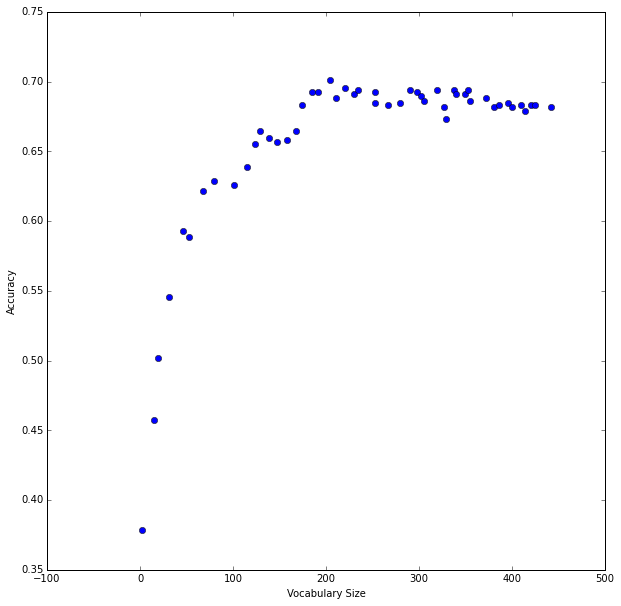

In [236]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    ### STUDENT START ###
    clf = LogisticRegression(penalty='l2')
    vect = CountVectorizer()
    count_trainL2 = vect.fit_transform(train_data)
    clf.fit(count_trainL2, train_labels)
    coefs = clf.coef_
    nnzL2 = 0 
    nnzFeatures = []
    features = vect.get_feature_names()
    # Find non-zero elements
    for i in range(0, len(coefs)):
        for j in range(0, len(coefs[i])):
            if coefs[i][j] != 0: nnzL2 = nnzL2 + 1
    
    clf = LogisticRegression(penalty='l1')
    vect = CountVectorizer()
    count_trainL1 = vect.fit_transform(train_data)
    clf.fit(count_trainL1, train_labels)
    coefs = clf.coef_
    nnzL1 = 0
    # Find non-zero elements and store corresponding features
    for i in range(0, len(coefs)):
        for j in range(0, len(coefs[i])):
            if coefs[i][j] != 0: 
                nnzL1 = nnzL1 + 1
                nnzFeatures.append(features[j])
    
    # Parse unique non-zero features
    nnzFeatures = list(set(nnzFeatures))
    print "L1 Number of non-zero learned weights: " + `nnzL1`
    print "L2 Number of non-zero learned weights: " + `nnzL2`

    count_dev = vect.transform(dev_data)
    # run for 50 C values between 0.001 and 0.25
    cValues = np.linspace(0.001, 0.25, 50)
    vocabSizes = []
    accuracies = []
    
    for c in cValues:
        clf = LogisticRegression(C=c, penalty='l1', tol = 0.01)
        clf.fit(count_trainL1, train_labels)
        # Find non-zero cases
        indices = np.sum(clf.coef_ != 0, axis = 0) > 0
        accuracy = clf.score(count_dev, dev_labels)
        
        # Store word in vocabulary if non-zero weight
        vocab = []
        for key, value in vect.vocabulary_.iteritems():
            if indices[value]:
                vocab.append(key)
        
        # Find accuracy of L2 linear regression with new vocabulary
        vectP = CountVectorizer(vocabulary=vocab)
        count_trainP = vectP.transform(train_data)
        count_devP = vectP.transform(dev_data)
        vocabSizes.append(count_trainP.shape[1])
        
        clf = LogisticRegression(penalty='l2', tol = 0.01)
        clf.fit(count_trainP, train_labels)
        accuracy = clf.score(count_devP, dev_labels)
        accuracies.append(accuracy)
    
    # Plot vocab size vs accuracy
    plt.figure(figsize=(10, 10))
    plt.plot(vocabSizes, accuracies, 'o')
    plt.xlabel('Vocabulary Size')
    plt.ylabel('Accuracy')
    plt.axis([-100, 500, 0.35, 0.75])
    print    
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [247]:
def P7():
    ### STUDENT START ###
    clf = LogisticRegression(C=100)
    vect = TfidfVectorizer()
    tfidf_train = vect.fit_transform(train_data)
    clf.fit(tfidf_train, train_labels)
    tfidf_dev = vect.transform(dev_data)
    preds = clf.predict(tfidf_dev)     
    f1_score = metrics.f1_score(dev_labels, preds)
    print "F1 score for TfidfVectorizer: " + `f1_score`
    
    post = clf.predict_proba(tfidf_dev)
    R = []
    # Calculate R for each feature
    for i in range(0, len(dev_labels)):
        r = post[i][preds[i]] / post[i][dev_labels[i]]
        R.append((r, preds[i], dev_labels[i], dev_data[i]))

    # Sort by R descending
    R.sort(key=lambda x:x[3], reverse = True)
    for i in range(0, 3):
        print "Predicted: " + `newsgroups_train.target_names[R[i][1]]`
        print "Correct: " + `newsgroups_train.target_names[R[i][2]]`
        print "R: " + `R[i][0]`
        print R[i][3]
        print "===================================="
    ### STUDENT END ###
P7()

F1 score for TfidfVectorizer: 0.75976624278531035
Predicted: 'comp.graphics'
Correct: 'comp.graphics'
R: 1.0
zyda@cs.nps.navy.mil (Michael Zyda) notes:


I had the same problem and called the people who handle the box; the
problem happened some time ago and was caught almost instantly.  All
registrations going to that address are now fixed.  See what trouble
you get into when you don't procrastinate, Mike?

And no, SIGGRAPH 93 has not skipped town -- we're preparing the best
SIGGRAPH conference yet!
Predicted: 'talk.religion.misc'
Correct: 'talk.religion.misc'
R: 1.0
unfortunately not


Predicted: 'alt.atheism'
Correct: 'alt.atheism'
R: 1.0
rh> From: house@helios.usq.EDU.AU (ron house)
rh> Newsgroups: alt.atheism
rh> Organization: University of Southern Queensland



rh> I _know_ I shouldn't get involved, but...   :-)

rh> [bit deleted]

[rest of rant deleted]

This is a standard argument for fundies.  Can you spot the falicy? The
statement is arguing from the assumption that Jesus act

ANSWER: Both of the top 2 documents have "ftp" in its text, which is resulting in a misprediction of "comp.graphics" instead of the correct "talk.religion.misc".

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance